# Receptive field demo

__Dr. Stephen David__


* Demonstrate basic methodologies for estimation of encoding models using a "toy",
  two-dimensional input space

* Input is Gaussian white noise, which can contain correlations between channels,
  mimicking the correlations that occur in natural sounds. (set CORR_INPUTS=True)

* The output can pass through a static nonlinearity, illustrating limitations of
  a completely linear model, especially in generalizing to stimuli outside of the
  space used for fitting. (set NONLIN=True)

Load the relevant libraries for analysis and plotting. 
* Note that strflib is not a native python library. It is a python file located in this working directory that contains useful functions for this analysis. This is a nice way to store useful functions that you find yourself using often during your analyses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import strflib

## Inititalize filter and input

Set parameters

In [2]:
# define filter
h1=np.array([[.5], [0]])
dimcount=h1.shape[0]
h0=np.zeros([1,1])

CORR_INPUTS=True   # should input channels be correlated?
NONLIN=True   # static nonlinearity at output?

# parameters of static NL (if used)
sigmoid_parms=np.array([-1, 2, 0.75, 0.08])

if CORR_INPUTS:
    # gaussian noise stimulus covariance matrix has non-zero off-diagonal terms
    s=np.array([[1.0, 0.7], [0.7, 1.0]])
    sout=np.array([[0.2, 0.1], [0.1, 0.2]])
else:
    # gaussian noise stimulus covariance matrix has zero off-diagonal terms
    s=np.array([[1.0, 0], [0, 1.0]])
    sout=np.array([[1.0,0],[0,1.0]])
    
# mean of output -- shifted for the "out of class" test set
m=np.zeros([dimcount,1])
mout=np.matrix([[2],[2]])

# gaussian additive noise
noiseamp=0.05

# number of samples for estimation/testing
T=dimcount*100

Generate the input and pass it through the linear filter based on above parameters

In [3]:
# generate inputs
xfit=strflib.gnoise(m,s,T)
xval=strflib.gnoise(m,s,T)
xoutval=strflib.gnoise(mout,sout,T)

# linear filter
yfit=np.matmul(h1.T,xfit)
yval=np.matmul(h1.T,xval)
youtval=np.matmul(h1.T,xoutval)


## Visualize the input to the model and the filtered output ("response")

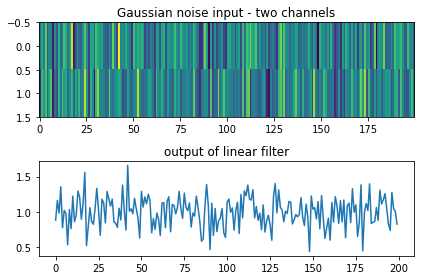

In [4]:
plt.figure()
plt.subplot(211)
plt.imshow(xoutval,aspect='auto')
plt.title('Gaussian noise input - two channels')

plt.subplot(212)
plt.plot(youtval.squeeze())
plt.title('output of linear filter')

plt.tight_layout()
plt.show()

__Pass ouput through a static nonlinearity if NONLIN == True__

In [5]:

if NONLIN:
    # pass output of filter through sigmoid (if specified)
    yfit=strflib.logsig_fn(sigmoid_parms,yfit)
    yval=strflib.logsig_fn(sigmoid_parms,yval)
    youtval=strflib.logsig_fn(sigmoid_parms,youtval)
    

if noiseamp>0:
    # add noise (if specified)
    yfit=yfit+strflib.gnoise(np.zeros([1,1]),np.matrix([[noiseamp]]),T)
    yval=yval+strflib.gnoise(np.zeros([1,1]),np.matrix([[noiseamp]]),T)
    youtval=youtval+strflib.gnoise(np.zeros([1,1]),np.matrix([[noiseamp]]),T)

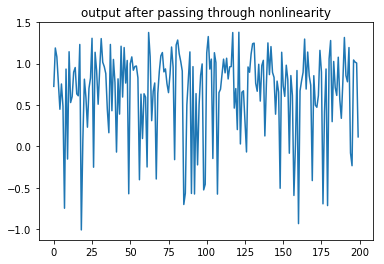

In [6]:
plt.figure()
plt.title('output after passing through nonlinearity')
plt.plot(youtval.squeeze())
plt.show()

## Now, fitting the model. Determine the filter that acted on the gaussian noise input to create the response above

Preprocess data

In [7]:
# subtract mean from stimulus and response to make them well-behaved
mx=np.mean(xfit,axis=1)
my=np.mean(yfit,axis=1)
xx=xfit-np.repeat(np.transpose(np.matrix(mx)),T,axis=1)
yy=yfit-my

__Compute the correlation between the stimulus (gaussian white noise) and response (pseudo-response that we generated above)__
* This is called the spike triggered average, or STA

In [8]:
# stimulus-response correlation  STA = S * r
SR= np.matmul(xx, yy.T) / T

__Compute stimulus autocorrelation__

In [9]:
# stimulus autocorrelation
C= np.matmul(xx, xx.T) / T

Illustration of the autocorrelation in the stimulus

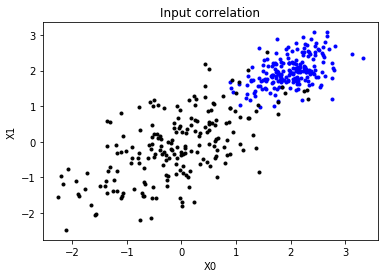

In [10]:
# plot X0 vs. X1 to illustrate stimulus autocorrelation (if specified)
plt.figure()
plt.plot(xoutval[0,:],xoutval[1,:],'b.')
plt.plot(xval[0,:],xval[1,:],'k.')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Input correlation')
plt.show()

__Normalize STA__

In [11]:
# sta is normalized by stimulus variance
hsta= ((1/np.diag(C)) * np.array(SR.T)).T

__Estimate the filter using two different methods__
* First, use linear regression, aka reverse correlation
* Second, use fancy method - coordinate descent, aka boosting

In [12]:
# estimate filter using normalized reverse correlation (aka linear regression)
Cinv=np.linalg.inv(C)
hnrc= np.matmul(Cinv, hsta)

# estimate filter using coordinate descent (aka boosting)
(hcd,hcd0)=strflib.coordinate_descent(xfit,yfit,0)

starting CD: n_params=2, step size: 0.100000 tolerance: 0.000100
1: best step=0,0 error=0.810195709264, delta=0.189804290736
2: best step=0,0 error=0.708184068796, delta=0.102011640467
3: best step=0,0 error=0.693965078598, delta=0.0142189901984
4: Backwards (delta=-0.0142189901984), adjusting step size to 0.05
5: best step=0,1 error=0.690100492413, delta=0.0180835763828
6: Backwards (delta=-0.00386458618441), adjusting step size to 0.025
7: best step=0,0 error=0.689289265185, delta=0.00467581341311
8: best step=1,1 error=0.688949056913, delta=0.00034020827137
9: Backwards (delta=-0.000304633701022), adjusting step size to 0.0125
10: best step=1,0 error=0.68836400569, delta=0.000889684924409
11: Backwards (delta=-0.000559231698306), adjusting step size to 0.00625
12: best step=1,1 error=0.688467742462, delta=0.000455494926381
13: best step=0,0 error=0.688302689559, delta=0.000165052902909
14: Backwards (delta=-0.000165052902909), adjusting step size to 0.003125
15: best step=1,0 error=

## Visualize the resulting filters from each of these methods

__Define the slope of the true underlying system (relationship between input and output that we defined above)__
* This will be plotted in red below, next to the prediction in blue

In [13]:
# slope of true underlying system
xr=np.array([[np.min(xval[0,:])],[np.max(xval[0,:])]])
yr0=xr * h1[0,0] + h0
yr1=xr * h1[1,0] + h0

__Results for STA - linear regression (reverse correlation)__
* Before normalizing for autocorrelations in the stimulus

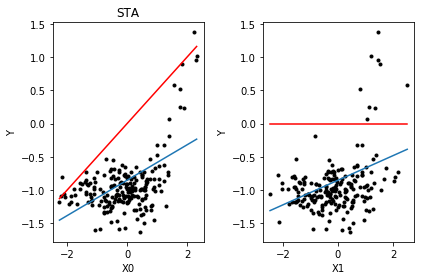

In [14]:
# STA results
plt.figure()
plt.subplot(1,2,1)
plt.plot(xval[0,:],yval[0,:],'k.')
xr=np.array([[np.min(xval[0,:])],[np.max(xval[0,:])]])
yr=xr * hsta[0,0] + my
plt.plot(xr,yr,'-')
yr0=xr * h1[0,0] + h0
plt.plot(xr,yr0,'r-')
plt.title('STA')
plt.xlabel('X0')
plt.ylabel('Y')

plt.subplot(1,2,2)
plt.plot(xval[1,:],yval[0,:],'k.')
xr=np.array([[np.min(xval[1,:])],[np.max(xval[1,:])]])
yr=xr * hsta[1,0] + my
plt.plot(xr,yr,'-')
plt.plot(xr,yr1,'r-')
plt.xlabel('X1')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

__Results for STA - linear regression (reverse correlation)__
* After normalizing for autocorrelations in the stimulus - notice the improvement in slope prediction for channel 2 (X1)

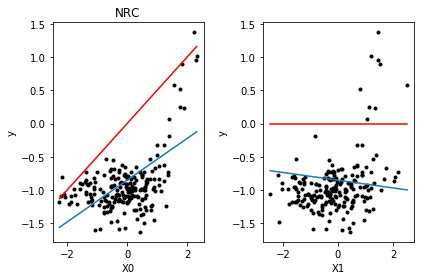

In [15]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(xval[0,:],yval[0,:],'k.')
xr=np.array([[np.min(xval[0,:])],[np.max(xval[0,:])]])
yr=xr * hnrc[0,0] + my
plt.plot(xr,yr,'-')
plt.plot(xr,yr0,'r-')
plt.xlabel('X0')
plt.ylabel('y')
plt.title('NRC')

plt.subplot(1,2,2)
plt.plot(xval[1,:],yval[0,:],'k.')
xr=np.array([[np.min(xval[1,:])],[np.max(xval[1,:])]])
yr=xr * hnrc[1,0] + my
plt.plot(xr,yr,'-')
plt.plot(xr,yr1,'r-')
plt.xlabel('X1')
plt.ylabel('y')

plt.tight_layout()
plt.show()

__Finally, results using coordinate descent__

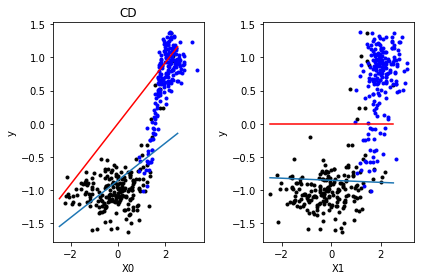

In [16]:
plt.figure()
plt.subplot(1,2,1)
yr=xr * hcd[0,0] + hcd0
plt.plot(xval[0,:],yval[0,:],'k.')
#if NONLIN:
plt.plot(xoutval[0,:],youtval[0,:],'b.')
plt.plot(xr,yr0,'r-')
plt.plot(xr,yr,'-')
plt.title('CD')
plt.xlabel('X0')
plt.ylabel('y')

plt.subplot(1,2,2)
yr=xr * hcd[1,0] + hcd0
plt.plot(xval[1,:],yval[0,:],'k.')
#if NONLIN:
plt.plot(xoutval[1,:],youtval[0,:],'b.')
plt.plot(xr,yr1,'r-')
plt.plot(xr,yr,'-')
plt.xlabel('X1')
plt.ylabel('y')

plt.tight_layout()

plt.show()

# Overall Results
* The model fitting is telling us that in all cases, the pseudo-neuron seems to care more about the first channel of gaussian noise (X0) than the second channel (X1). We can tell this based on the fact that the slope between X0 and y (first channel and output) is greater thatn the slope between X1 and y (second channel and output). This could be compared to an auditory neuron that responds preferentially to one frequency.

* Using these results, we are able to now predict neural responses using a weighted sum of the two channel inputs.